import modules

In [2]:
# !pip install geopy
# !pip install pyserial

import urllib.request
import pprint
import json
import datetime
import time
import math
import numpy as np
import geopy.distance
import matplotlib.pyplot as plt
import threading
import struct
import serial
from IPython import display
from ipywidgets import interact

connect to arduino

In [3]:
baud = 9600
port = '/dev/cu.usbmodem1421'
try:
    arduino = serial.Serial(port, baud)
    time.sleep(2)
    print("Connection to " + port + " established succesfully!\n")
except Exception as e:
    print(e)

Connection to /dev/cu.usbmodem1421 established succesfully!



In [4]:
def change_intensity(intensity=0):
    arduino.write(struct.pack('>B', int(intensity*2.5)))
    print("intensity", intensity)

In [5]:
interact(change_intensity, intensity=(0, 100, 1))

intensity 0


<function __main__.change_intensity>

In [7]:
stuttgart_coordinates = (9.1829321, 48.7758459) 

decay = 0.01  # decay speed of the earthquake effect
seismic_wave_speed = 5000  # speed with which seismic waves propagate (in m/s)
time_span = 4.  # the time span from which to query earthquakes (in past hours)
min_magnitude = 0.  # the minimum magnitude of queried earthquakes
magnitude_base = 2.  # the exponential base for magnitude conversion 
                     # (the Richter scale has base 10, but this leads to extreme differences)

In [8]:
class Earthquakes():
    def __init__(self, 
                 location, 
                 decay=0.01, 
                 speed=3000, 
                 time_span=4., 
                 magninute_base=2.,
                 query_update_time=60):
        self.location = location
        self.decay = decay
        self.speed = speed
        self.time_span = time_span
        self.base = magninute_base
        self.query_update_time = query_update_time
        
        self.query_thread = threading.Thread(target=self.query_update)
        self.continue_updating = True
        self.query_thread.start()
        self.lock = threading.Lock()
        self.earthquakes = []
        
    def query_update(self):
        while self.continue_updating:
            eq = self.parse_geo_json_earthquakes(self.usgs_query())
            with self.lock:
                self.earthquakes = eq
            print("data updated")
            time.sleep(self.query_update_time)
        
    def usgs_query(self):
        """
        Query on the USGS database for earthquakes
        :param time_span: the time span in the past from which earthquakes are returned
        :param min_magnitude: the minimal magnitude a earthquake should have to be returned
        """
        
        start_time = time.time() - time_span * 3600 # eight hours before now
    
        query = "https://earthquake.usgs.gov/fdsnws/event/1/query?format=geojson"
    
        time_string = datetime.datetime.fromtimestamp(start_time).strftime('%Y-%m-%dT%H:%M:%S')
        query += "&starttime=" + time_string
        query += "&minmagnitude=" + str(min_magnitude)
        query += "&orderby=time"
        
        x = urllib.request.urlopen(query)
        data = x.read()
        parsed_data = json.loads(data.decode())
        return parsed_data
    
    def parse_geo_json_earthquakes(self, json_data):
        """
        return a list of formatted earthquak dicts from raw json data
        """
        
        earthquakes_raw = json_data["features"]
        print("Number of earthquakes:", len(earthquakes_raw))
        earthquakes = [self.parse_earthquake(f) for f in earthquakes_raw]
        return earthquakes

    def parse_earthquake(self, features):
        """
        parse the earthquake features from the GeoJSON format to a dict containing distance, magnitude and time
        """
        
        this_quake = {}
        prop = features['properties']
        coordinates = features['geometry']['coordinates']
        this_quake['distance'] = geopy.distance.vincenty(self.location, (coordinates[0], coordinates[1])).meters
        this_quake['magnitude'] = prop['mag']
        quake_time = prop['time'] / 1000.
        this_quake['time'] = quake_time
        return this_quake
    
    def earthquake_effect(self, quake, time=time.time()):
        """
        calculate the effect an earthquake has at the given time 
        (with exponential decay and weighted quadratically with respect to distance)
        """
        
        traveling_time = quake['distance'] / self.speed
        elapsed_time = time - quake['time']
        effective_time = elapsed_time - traveling_time
        if effective_time < 0:
            return 0
        effect = math.exp(-effective_time * decay)
        effect *= self.base**quake['magnitude']
        effect *= 1 / (quake['distance']*0.000001)**2
        return effect
    
    def effect(self, time=time.time()):
        effect = 0
        with self.lock:
            for q in self.earthquakes:
                effect += self.earthquake_effect(q, time)
        return effect
    
    def plot_effect(self, past=240, future=30):
        current_time = time.time()
        y = np.zeros(future + past)
        x = np.linspace(-past, future, num=future+past)
        for m in range(future + past):
            position = (m - past) * 60.
            y[m] = self.effect(time=current_time + position)
        display.clear_output(wait=True)
        display.display(plt.gcf())
        plt.plot(x, y)
        plt.plot(0, self.effect(current_time), 'o')
        plt.show()
        

In [9]:
earthquakes = Earthquakes(stuttgart_coordinates)

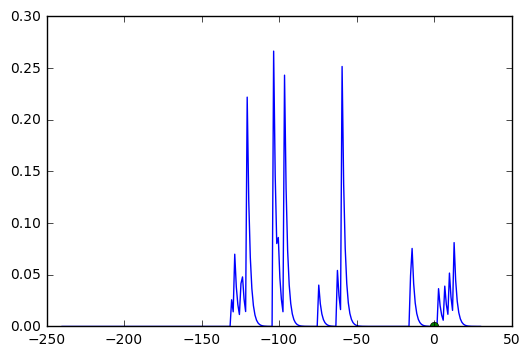

In [11]:
pprint.pprint(earthquakes.earthquakes)
earthquakes.plot_effect()

In [8]:
while True:
    current_effect = earthquakes.effect(time=time.time())
    # print("effect: ", current_effect)
    scaled_effect = min(int(current_effect*250), 500)
    arduino.write(struct.pack('>B', scaled_effect))
    time.sleep(1)

effect:  0.00022634998197652653
effect:  0.00022409501899332119
effect:  0.0002218630019490102
effect:  0.00021965293278147698
effect:  0.0002174626070745104
effect:  0.00021529648190879994
effect:  0.00021315288821631724
effect:  0.00021103063514484182
effect:  0.00020892952071778666
Number of earthquakes: 20
data updated
effect:  0.0002068490630581702
effect:  0.0002047895944204084
effect:  0.0002027505151111887


KeyboardInterrupt: 

In [24]:
prob = int(10)
while True:
    arduino.write(struct.pack('>B', prob))
    time.sleep(1)

Number of earthquakes: 18
data updated
Number of earthquakes: 17
data updated


KeyboardInterrupt: 

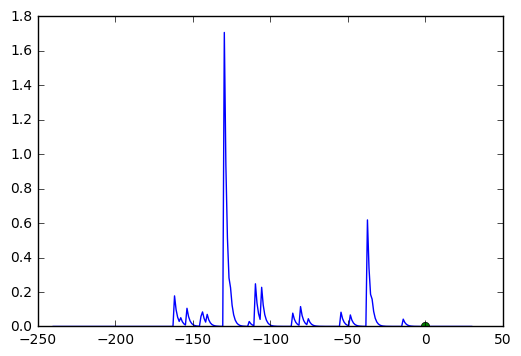

In [4]:
earthquakes = parse_geo_json_earthquakes(earthquake_query(time_span, min_magnitude))
plot_earthquake_effects(earthquakes, decay=decay, speed=seismic_wave_speed, base=magnitude_base)

In [7]:
from matplotlib import animation

%matplotlib notebook
# First set up the figure, the axis, and the plot element we want to animate
fig = plt.figure()
ax = plt.axes(xlim=(0, 2), ylim=(-2, 2))
line, = ax.plot([], [], lw=2)

# initialization function: plot the background of each frame
def init():
    line.set_data([], [])
    return line,

# animation function.  This is called sequentially
def animate(i):
    x = np.linspace(0, 2, 1000)
    y = np.sin(2 * np.pi * (x - 0.01 * i))
    line.set_data(x, y)
    return line,

# call the animator.  blit=True means only re-draw the parts that have changed.
anim = animation.FuncAnimation(fig, animate, init_func=init,
                               frames=200, interval=20, blit=True)

# save the animation as an mp4.  This requires ffmpeg or mencoder to be
# installed.  The extra_args ensure that the x264 codec is used, so that
# the video can be embedded in html5.  You may need to adjust this for
# your system: for more information, see
# http://matplotlib.sourceforge.net/api/animation_api.html
anim.save('basic_animation.mp4', fps=30, extra_args=['-vcodec', 'libx264'])

plt.show()

<IPython.core.display.Javascript object>

In [10]:
!pip install pyserial

    100% |████████████████████████████████| 194kB 1.8MB/s 
You are using pip version 8.1.2, however version 9.0.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


In [17]:
import struct
import serial

baud = 9600
port = '/dev/cu.usbmodem1411'
try:
    arduino = serial.Serial(port, baud)
    time.sleep(2)
    print("Connection to " + port + " established succesfully!\n")
except Exception as e:
    print(e)
    
for i in range(251):
    arduino.write(struct.pack('>B', i))
    time.sleep(0.2)
    
for i in range(251):
    arduino.write(struct.pack('>B', 250-i))
    time.sleep(0.2)

[Errno 16] could not open port /dev/cu.usbmodem1411: [Errno 16] Resource busy: '/dev/cu.usbmodem1411'
